# Lecture #13: Stochastic Gradient Descent and Simulated Annealing
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2021

##### <img src="fig/logos.jpg" style="height:150px;">

In [1]:
### Import basic libraries
from autograd import numpy as np
from autograd import grad
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.datasets.samples_generator import make_blobs
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
%matplotlib inline

## Outline
1. Generalized Linear Models
2. Stochastic Gradient Descent
3. Non-Convex Optimization
4. Simulated Annealing

# Generalized Linear Models

## A New Model: Logistic Regression

A logistic regression model is just a Bernoulli model $Y^{(n)} \sim Ber(\theta_n)$ model, where $\theta^{(n)}$ depends on a set of covariates $\theta^{(n)} =\mathrm{sigm}(f(\mathbf{X}; \mathbf{w}))$. For now, we assume that $f(\mathbf{X}; \mathbf{w}) = \mathbf{w}^\top \mathbf{X}$.

**Question:** What's the big deal about modeling with covariates?

1. A logistic regression model is more flexible because it does not assume that all observations $Y^{(n)}$ are identically distributed. We can model interesting variations in the data by assuming a different $\theta^{(n)}$ for each $Y^{(n)}$ (this is what we did for each movie in the IMDB dataset and for each county in the Kidney Cancer dataset).<br><br>

2. By making the variations in $\theta^{(n)}$ explicitly depend on measurable factors $\mathbf{X}$, we can ***explain*** the data in addition to modeling it. Suppose you found that 
$$\mathbf{w}_{\text{MLE}} = [-1\;\;3\;\;1.5\;\;1.75]$$ 
and so your MLE model is $Y^{(n)}\sim Ber(\mathrm{sigm}(\mathbf{w}_{\text{MLE}}^\top \mathbf{X}))$:

$$
\underbrace{p(y=1 | x_1, x_2, x_3)}_{\text{$Y$ presence of kidney cancer}} = \mathrm{sigm}(-1 + 3 \underbrace{x_1}_{\text{gene Z}} + 1.5 \underbrace{x_2}_{\text{cholestrol}} - 1.75 \underbrace{x_3}_{\text{Hemo. A1C}}).
$$

## Generalized Linear Models

We can add covariates to all the other common statistical models of data $Y^{(n)} \sim p(Y^{(n)}|\theta^{(n)})$!

The general scheme is:

1. Set $\mathbb{E}[Y^{(n)}] = \theta^{(n)} = g(\mathbf{w}^\top \mathbf{X}^{(n)})$, where $g$ is typically a non-linear function called the ***link function*** (in literature, $g^{-1}$ is called the link function).
2. Set the variance according to how the variance of $p(Y^{(n)}|\theta^{(n)})$ depends on $\theta$, $\mathrm{Var}[Y^{(n)}] = \phi f(\theta^{(n)})$, where $\phi$ is a constant.

These models are called ***generalized linear models***. Logistic regression is so called because $g^{-1}$ is the ***logistic function***.

**For example:** If $Y^{(n)} \sim Poi(\lambda^{(n)})$, we know that $\mathbb{E}[Y^{(n)}] = \mathrm{Var}[Y^{(n)}] = \lambda^{(n)}$. So we can replace $\lambda^{(n)}$ with a linear function of $\mathbf{X}$:

$$
\lambda^{(n)} = e^{\mathbf{w}^\top \mathbf{X}^{(n)}}.
$$

The link function we chose is $e^x$, can you see why we made this choice? 

# Model Selection for Hierachical Generalized Linear Models

## How Many Covariates to Include?

Now we can inject covariates into any distribution $Y^{(n)} \sim p(Y | \theta)$, by making $\theta$ a function of $\mathbf{X}$. Doing so allows us to explain the distribution of the outcome $Y$ based on explanatory factors $\mathbf{X}$. 

In fact, **the more covaraiates you use, the better your model will fit the data**. 

But interpreting the model becomes problemmatic when the covariates are not independent of each other.

## The Dangers of Model Interpretation

For example, suppose that you are modeling kidney cancer using a logistic regression model with $\mathbf{X} = \{\text{age}, \text{smoker}\}$. Suppose that the maximum likelihood model you found is

$$
\mathrm{Prob}[Y = 1| \mathbf{X}, \mathbf{w}] = \mathrm{sigm}(-5 * \text{age} - 0.2 * \text{smoker} - 0.5)
$$

What happens if you included more covariates: $\mathbf{X} = \{\text{age}, \text{video games (hr)}, \text{smoker}\}$? If the new covariates are correlated with existing ones, e.g. 

$$\text{video games (hr)} = 0.5 * \text{age},$$ 

then the model weights can change drastically:

$$
\mathrm{Prob}[Y = 1| \mathbf{X}, \mathbf{w}] = \mathrm{sigm}(0.5 * \text{age} - 11 * \text{video games (hr)} - 0.2 * \text{smoker} - 0.5)
$$

Note, both models will fit the observed data equally well!

## Model Selection through Cross-Validation
If one of these models captures the true relationship between the covariates and the risk of kidney cancer, then it will ***generalize*** (fit new data) well.

\begin{align}
(\text{Model 1})\quad \mathrm{Prob}[Y = 1| \mathbf{X}, \mathbf{w}] &= \mathrm{sigm}(-5 * \text{age} - 0.2 * \text{smoker} - 0.5)\\
(\text{Model 2})\quad \mathrm{Prob}[Y = 1| \mathbf{X}, \mathbf{w}] &= \mathrm{sigm}(0.5 * \text{age} - 11 * \text{games} - 0.2 * \text{smoker} - 0.5)
\end{align}

In other words, if one of these models is capturing spurious connections between the covariates and the outcome, then it should fail on new data where this connection doesn't hold (e.g. when we collect data on older individuals who play a lot of video games).

One way to simulate the model's performance on new data is to randomnly hold-out different parts of the observed data during inference (we train on the remaining data) and use the held-out data to test the performance of the model. We select the model that has the best performance, on average, on held-out data. This is called ***cross-validation***. 

Note: in cross validation you are re-training your model multiple times. This can be prohibitively expensive!

## Model Selection for Maximum Likelihood Models

An alternative to model selection via cross-validation is to directly approximate the model's performance on new data. We evaluate predictive accuracy using the log-likelihood of the observed data:
$$
D(y|\mathbf{w}_{\text{MLE}}) = -2\sum_{n=1}^N\log p\left(Y^{(n)}|\mathbf{X}^{(n)}, \mathbf{w}_{\text{MLE}}\right)
$$
We know that this is an overestimate of the log-likelihood of new data under the model. So a correction must be made. This correction is typically the complexity of the model, i.e. the dimension of $\mathbf{w}$:

1. (**Akaike's Information Criterion**) $$\text{AIC} = D(y|\mathbf{w}_{\text{MLE}}) + 2\,\mathrm{dim}(\mathbf{w}_{\text{MLE}})$$

2. (**Bayesian Information Criterion**) $$\text{BIC} = D(y|\mathbf{w}_{\text{MLE}}) + \log(N)\,\mathrm{dim}(\mathbf{w}_{\text{MLE}})$$

The smaller the number the better. Intuitively, each criterion is encoding a form of Occam's Razor.

The validity of each criterion is argued asymptotically, assuming a number of specific modeling conditions -- in practice, use with caution!

## Model Selection Via Evidence

For Bayesian models, there is a natural way to compare different classes of models $M \in \mathcal{M}$ for a fixed dataset $Y^{\mathrm{Obs}}$ via the **evidence** $p(Y^{\mathrm{Obs}} | M)$, i.e. the average likelihood of the observed data under the models in the prior:

$$
p(Y^{\mathrm{Obs}} | M) = \int p(Y^{\mathrm{Obs}} | \mathbf{w}) p(\mathbf{w} |M) d\mathbf{w}
$$

where $p(\mathbf{w} |M)$ is the prior over the parameters $\mathbf{w}$ for the model class $M$. 

Since the evidence is a measure of how likely is the data under the model class $M$, it naturally implies Occam's Razor - since models from a very complex model classes can generate a wide range datasets, they are unlikely to generate any particular one (our dataset for example); models from very simple model classes are unlikely to fit our data and hence unlikely to generate our dataset.

<img src="fig/evidence.png" style="height:200px;">

## Model Selection Via Bayes Factor

Why is this comparison principled? It's more natural to compare the *likelihood of different models given our data*, $p(M|Y^{\mathrm{Obs}})$. For this we need to assume a prior distribution $p(M)$ over the model classes in $\mathcal{M}$ and compute the posterior over model classes:

$$
p(M|Y^{\mathrm{Obs}}) = \frac{\overbrace{p(Y^{\mathrm{Obs}} | M)}^{\mathrm{evidence}}\overbrace{p(M)}^{\text{prior over models}}}{p(Y^{\mathrm{Obs}})}
$$

But $p(Y^{\mathrm{Obs}})$ can't be computed! So to perform model selection between $M_1, M_0 \in \mathcal{M}$ we can compute their posterior ratio, which eliminates $p(Y^{\mathrm{Obs}})$:

$$
\frac{p(M_1|Y^{\mathrm{Obs}})}{p(M_0|Y^{\mathrm{Obs}})} = \frac{p(Y^{\mathrm{Obs}} | M_1)}{p(Y^{\mathrm{Obs}} | M_0)}\frac{p(M_1)}{p(M_0)}
$$

When we assume a uniform likelihood over the model classes in $\mathcal{M}$, this ratio is just $\frac{p(Y^{\mathrm{Obs}} | M_1)}{p(Y^{\mathrm{Obs}} | M_0)}$, called the **Bayes Factor**, and it reduces to comparing the evidence of the data under the two models.

## Model Selection for Bayesian Models

But ***evidence is hard to compute***! For Bayesian models we evaluate the predictive accuracy using the (point-wise) log posterior predictive likelihood (lppd) of the observed data:

\begin{align}
\mathrm{lppd} &= \sum_{n=1}^N\log \int p\left(Y^{(n)}|\mathbf{X}^{(n)}, \mathbf{w}\right) p(\mathbf{w} | \text{Data}) d\mathbf{w}\\
&= \sum_{n=1}^N\log\mathbb{E}_{\mathbf{w} \sim p(\mathbf{w} | \text{Data})}\left[p\left(Y^{(n)}|\mathbf{X}^{(n)}, \mathbf{w}\right) \right].
\end{align}

Again, this is an overestimate of the log-likelihood of new data under the posterior. So a correction must be made. In this case, the correction is the (point-wise) variance of the log posterior predictive likelihood

$$
p_{\text{WAIC}} = \sum_{n=1}^N\log\mathrm{Var}_{\mathbf{w} \sim p(\mathbf{w} | \text{Data})}\left[p\left(Y^{(n)}|\mathbf{X}^{(n)}, \mathbf{w}\right) \right].
$$

The ***Watanabe-Akaike information criterion (WAIC)*** is defined to be
$$
\mathrm{WAIC} = -2\, \mathrm{lppd} + 2\, p_{\text{WAIC}}.
$$
One may interpret $p_{\text{WAIC}}$ as an approximation of the effective number of parameters in the model (in a complex hierarchical model the "number of parameters" is not obvious to quantify).

# Inference for General Linear Models

## General Linear Models

We can add covariates to all the other common statistical models of data $Y^{(n)} \sim p(Y^{(n)}|\theta^{(n)})$!

The general scheme is:

1. Set $\mathbb{E}[Y^{(n)}] = \theta^{(n)} = g(\mathbf{w}^\top \mathbf{X}^{(n)})$, where $g$ is typically a non-linear function called the ***link function*** (in literature, $g^{-1}$ is called the link function).
2. Set the variance according to how the variance of $p(Y^{(n)}|\theta^{(n)})$ depends on $\theta$, $\mathrm{Var}[Y^{(n)}] = \phi f(\theta^{(n)})$, where $\phi$ is a constant.

These models are called ***general linear models***. Logistic regression is so called because $g^{-1}$ is the ***logistic function***.

## A New Inference Algorithm: Maximum Likelihood by Gradient Descent

We'd like to learn the parameters $\mathbf{w}_{\text{MLE}} = \underset{\mathbf{w}}{\mathrm{argmin}} \left(-\ell(\mathbf{w})\right)$. The derivative $\nabla_\mathbf{w} \left(-\ell(\mathbf{w})\right)$ is easy to derive but hard to solve for stationary points!

**Gradient descent:** we algorithmically find $\mathbf{w}^*$ such that the derivative $\nabla_\mathbf{w} \left(-\ell(\mathbf{w})\right)(\mathbf{w}^*)$ is approximately zero:

0. start at any $\mathbf{w}^{(0)}$
1. compute: $\nabla_\mathbf{w} \left(-\ell(\mathbf{w})\right)$ at $\mathbf{w}^{(current)}$
2. take a step in the negative gradient direction: 
$$\mathbf{w}^{(new)} \leftarrow \mathbf{w}^{(current)} - \eta * \nabla_\mathbf{w} \left(-\ell(\mathbf{w})\right)(\mathbf{w}^{(current)})$$

We repeat until the derivative is close to zero (stationary). 

This algorithm *"solves for"* the stationary point of $\nabla_\mathbf{w} \left(-\ell(\mathbf{w})\right)$ for us!

**Question:** Can we use gradient descent to solve other hard optimization problem we've seen in this class?

## Subtlties of Gradient Descent: Local vs Global Minima

If the objective function is ***convex*** and the constraints define a ***convex feasible set***, then a stationary point of the objective function gradient or Lagrangian gradient is also a global minimum of the optimization problem.

If the optimization problem is nonconvex then ***there is no guarantee*** that when gradient descent converges, you've found anything close to a global minimum!

<img src="./fig/nonconvex.jpg" style='height:300px;'>

## Where does Non-Convexity Come From?

1. (**Link Functions**) General linear models with monotone increasing link functions have convex negative log-likelihoods (with respect to a specific parametrization). However, in some cases, we may wish to choose link functions that are not monotone increasing.<br><br>

2. (**Constraints**) Often, we maximize constrained (or regularized) version of the likelihood. These constraints may not always define convex feasible sets.<br><br>

3. (**Non-Linear Dependency on $\mathbf{w}$**) In our logistic regression model, $Y^{(n)} \sim Ber(\mathrm{sigm}(f(\mathbf{X}; \mathbf{w})))$, we can choose a function $f$ that is non-linear in $\mathbf{w}$ (it'll be a neural network later).

## Subtlties of Gradient Descent: Scalability

For every likelihood optimization problem, evaluating the gradient at a set of parameters $\mathbf{w}$ requires evaluating the likelihood of the entire dataset using $\mathbf{w}$:

$$
\nabla_{\mathbf{w}} \ell(\mathbf{w}) = -\sum_{n=1}^N \left(y^{(n)} - \frac{1}{1 + e^{-\mathbf{w}^\top\mathbf{x}^{(n)}}} \right) \mathbf{x}^{(n)} =\mathbf{0}
$$

Imagine if the size of your dataset $N$ is in the millions. Naively evaluating the gardient **just once** may take up to seconds or minutes, thus running gradient descent until convergence may be unachievable in practice!

**Idea:** Maybe we don't need to use the entire data set to evaluate the gradient during each step of gradient descent. Maybe we can approximate the gradient at $\mathbf{w}$ well enough with just a subset of the data.

# Stochastic Gradient Descent

## Mini-batch Evaluation of the Gradient

Rather than computing the gradient of the negative log-likelihood at every $\mathbf{w}$ using the entire dataset, we can **approximate** the true gradient at $\mathbf{w}$ by computing the gradient of the negative log-likelihood using a subset of $N/K$ number of observations. 

This modified gradient descent algorithm is called ***mini-batch gradient descent***:
0. Start at initial value $\mathbf{w}^{(0)}$.
1. For `epochs` $= 1, \ldots, $ `total_epochs`:
  1. Shuffle the data and divide up into $K$-chunks each with $N/K$ observations
  2. For $k =1, \ldots K$:
    1. Compute `grad`$(\mathbf{w}) = -\nabla_{\mathrm{w}} \prod_{n=1}^{N/K} p(y^{(n)} |\mathrm{x}^{(n)}, \mathbf{w})$, where $y^{(n)}, \mathrm{x}^{(n)}$ are from the $k$-th chunk.
    2. Evaluate `grad`$(\mathbf{w}^{(current)})$.
    3. Set $\mathbf{w}^{(new)} \leftarrow \mathbf{w}^{(current)} - \eta *$ `grad`$(\mathbf{w}^{(current)})$
    
In the extreme case, we choose each chunk to have only 1-observation, the algorithm reduces to randomly selecting an observation to compute the gradient in each iteration.

## Mini-batch Evaluation as Stochastic Gradients

Since the gradient of the negative log-likelihood in each iteration is **approximated** using a random subset of the data, this approximation introduces ***stochasticity*** into the descent algorithm. That is, we can reframe mini-batch gradient descent as ***stochastic gradient descent***:

0. Start at initial value $\mathbf{w}^{(0)}$.
1. Compute: $\nabla_\mathbf{w} \left(-\ell(\mathbf{w})\right)$ at $\mathbf{w}^{(current)}$
2. Take a **stochastic step** in the negative gradient direction: 
$$\mathbf{w}^{(new)} \leftarrow \mathbf{w}^{(current)} - \eta * \nabla_\mathbf{w} \left(-\ell(\mathbf{w})\right)(\mathbf{w}^{(current)}) + \epsilon$$

where $\epsilon\sim p(\epsilon)$ is a random variable with mean zero. 

If the negative log-likelihood is convex and we can compute the variance of $p(\epsilon)$, we can again prove that stochastic gradient descent (and hence mini-batch gradient descent) converges to the global minimum for an appropriate choice of $\eta$.

## Maximum Likelihood with Stochastic Gradient Descent

What is the difference between the performance of gradient descent and that of stochastic gradient descent on the logistic regression model? Which type of descent should we use for these models?

In [2]:
# generate 2d classification dataset
centers = [[0.5, 1], [-0.5, -1]]
X, y = make_blobs(n_samples=400, n_features=2, centers=centers)
X = np.hstack((X, np.ones((X.shape[0], 1))))

#define the sigmoid function
sigmoid = lambda z: 1. / (1. + np.exp(-z))

#define the negative log-likelihood
nll = lambda X, y, w:  -(y * np.log(sigmoid(X.dot(w))) + (1 - y) * np.log(1 - sigmoid(X.dot(w)))).sum()

#define logistic regression MLE inference by gradient descent
def logistic_regression_fit(X, y, init=None, batch_size=None, epochs=10, threshold=1e-6, total_iterations=1000, eta=1e-4):
    #implement the gradient
    gradient = lambda w, X, y: -((y - sigmoid(X.dot(w)))[:, np.newaxis] * X).sum(axis=0)
    
    #initialize parameters w
    if init is None:
        init = np.random.normal(0, 1, size=X.shape[1])
    w_current = init
    #store the negative log-likelihood
    nlls = []
    #store the norm of the gradients 
    grad_norms = []
    #initialize the difference between current and new parameters
    delta = 1
    i = 0
    if batch_size is None:
        #gradient descent 
        while i < total_iterations and delta > threshold:
            #compute the gradient
            grad = gradient(w_current, X, y)
            #update parameter by taking gradient step
            w_next = w_current - eta * grad
            #compute the difference between current parameters and new parameters
            delta = np.linalg.norm(w_next - w_current)
            #compute the norm of the gradient
            grad_norms.append(np.linalg.norm(grad))
            #compute the negative log-likelihood
            nlls.append(nll(X, y, w_current))

            w_current = w_next
            i += 1
    else:
        
        batches = int(len(X) / batch_size)
        for epoch in range(epochs):
            
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            
            for i in range(batches):
                if i == batches - 1:
                    batch_indices = indices[i * batch_size:]
                else:
                    batch_indices = indices[i * batch_size:(i + 1) * batch_size]
                
                #compute the gradient
                grad = gradient(w_current, X[batch_indices], y[batch_indices])
                #update parameter by taking gradient step
                w_next = w_current - eta * grad
                #compute the difference between current parameters and new parameters
                delta = np.linalg.norm(w_next - w_current)
                #compute the norm of the gradient
                grad_norms.append(np.linalg.norm(grad))
                #compute the negative log-likelihood
                nlls.append(nll(X, y, w_current))

                w_current = w_next
            
        
    return w_current, nlls, grad_norms

def plot_diagnostics(ax, nlls, nll_s):
    ax[0].plot(range(len(nlls)), nlls)
    ax[0].set_title('negative log-likelihood over iterations of gradient descent')
    ax[0].set_ylabel('negative log-likelihood')
    ax[0].set_xlabel('iterations of gradient descent')

    ax[1].plot(range(len(nll_s)), nll_s, color='red')
    ax[1].set_title('negative log-likelihood over iterations of stochastic gradient descent')
    ax[1].set_ylabel('negative log-likelihood')
    ax[1].set_xlabel('iterations of stochastic gradient descent')
    ax[1].set_xlim((0, 2000))
    return ax

np.random.seed(17)
init = np.random.normal(0, 1, size=X.shape[1])
w_MLE, nlls, grad_norms = logistic_regression_fit(X, y, init=init, threshold=1e-6, total_iterations=2000, eta=1e-2)
w_MLE_s, nlls_s, grad_norms_s = logistic_regression_fit(X, y, batch_size=1, epochs=10, eta=5e-2, init=init)

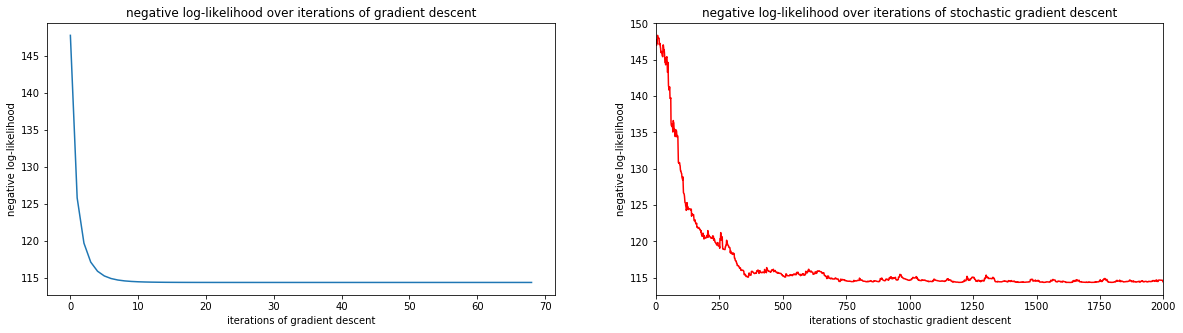

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax = plot_diagnostics(ax, nlls, nlls_s)
plt.show()

# Non-Convex Optimization

## A Non-Convex Optimization Example

In [4]:
def gradient_descent(f, grad, eta=1e-3, init=None, total_iterations=1000, threshold=1e-6):
    
    if init is None:
        init = np.random.normal(0, 1)
        
    x_current = init
    trace = [x_current]
    grad_norm = np.linalg.norm(grad(x_current))
    grad_norms = [grad_norm]
    obj_vals = [f(x_current)]
    i = 0
    
    while grad_norm > threshold and i < total_iterations:
        grad_current = grad(x_current)
        x_current -= eta * grad_current
        trace.append(x_current)
        grad_norm = np.linalg.norm(grad_current)
        grad_norms.append(grad_norm)
        obj_vals.append(f(x_current))
        i += 1
    
    return x_current, grad_norms, obj_vals, trace

In [5]:
#definition of our somewhat non-convex function
g = lambda x:  0.5 * x**6 - 6 * x**4 + 20 * x**2 + 0.5 * x + 1
#gradient function of g
grad_g = grad(g)

x = np.linspace(-3, 3, 200)

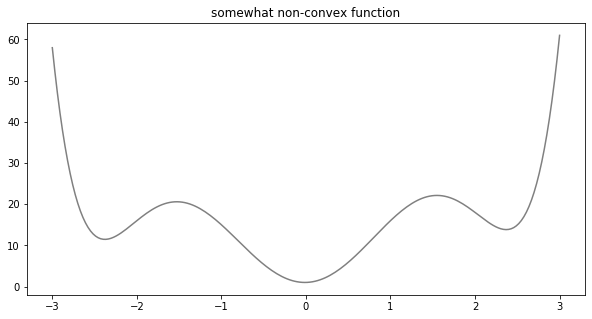

In [6]:
#plot our somewhat non-convex function
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, g(x), color='gray')
ax.set_title('somewhat non-convex function')
plt.show()

## Gradient Descent for Non-Convex Optimization

How would gradient descent perform when minimizing a non-convex objective function?

In [7]:
#initialization for gradient descent
init = 3.
#perform gradient descent
x_opt, grad_norms, obj_vals, trace = gradient_descent(g, grad_g, eta=1e-3, init=init, total_iterations=1000, threshold=1e-6)

#make an animation of the objective function height during gradient descent
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, g(x), color='gray')
ax.scatter(trace[0], obj_vals[0], color='red', label='objective function value during descent')

def animate(i):
    ax.scatter(trace[i], obj_vals[i], color='red')
    ax.set_xticks(list(range(-3, 4, 1)) + trace[:i+1])
    ax.set_xticklabels(list(range(-3, 4, 1)) + ['' for j in range(i + 1)])
    
animated_descent = matplotlib.animation.FuncAnimation(fig, animate, frames=len(trace), repeat=True)
ax.legend(loc='best')
ax.set_title('visualization of trajectory of gradient descent')
plt.close(fig)
rc('animation', html='html5')

In [8]:
animated_descent

## Stochastic Optimization for Non-Convex Optimization

How would stochastoic gradient descent perform when minimizing a non-convex objective function?

In [9]:
#initialization for gradient descent
init = 3.
#set random seed
np.random.seed(4)
#define a noisy (stochastic) version of the gradient of g
noisy_grad_g = lambda x: grad(g)(x) + np.random.normal(0, 60)
#perform stochastic gradient descent
x_opt, grad_norms, obj_vals, trace = gradient_descent(g, noisy_grad_g, eta=1e-3, init=init, total_iterations=1000, threshold=1e-6)

#make an animation of the objective function height during gradient descent
Writer = animation.writers['ffmpeg']
writer = Writer(fps=40, metadata=dict(artist='Me'), bitrate=1800)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, g(x), color='gray')
ax.scatter(trace[0], obj_vals[0], color='red', label='objective function value during descent')

def animate(i):
    ax.scatter(trace[i], obj_vals[i], color='red')
    ax.set_xticks(list(range(-3, 4, 1)) + trace[:i+1])
    ax.set_xticklabels(list(range(-3, 4, 1)) + ['' for j in range(i + 1)])
    
aninimated_descent_noisy = matplotlib.animation.FuncAnimation(fig, animate, frames=700, repeat=True)
ax.legend(loc='best')
ax.set_title('visualization of trajectory of stochastic gradient descent')
plt.close(fig)
rc('animation', html='html5')

In [10]:
aninimated_descent_noisy

## Another Non-Convex Optimization Example

In [11]:
#define our extremely non-convex function f
a = 0.1
b = 0.1
c = 5
f = lambda x: 0.5 * (x - b)**2 + a * x**2 * np.cos(np.pi * x) - c * np.sin(2 * np.pi * x) + np.cos(4 * np.pi * x) * np.sin(np.pi * x)
#define the gradient function of f
grad_f = grad(f)

x = np.linspace(-10, 10, 200)

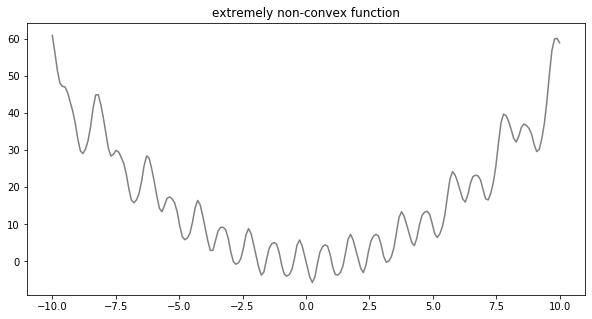

In [12]:
#plot our extremely non-convex function f
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, f(x), color='gray')
ax.set_title('extremely non-convex function')
plt.show()

## Stochastic Optimization for Non-Convex Optimization

How would gradient descent perform when minimizing a non-convex objective function?

In [13]:
#initialization for gradient descent
init = 10.
#set random seed
np.random.seed(3)
#define a noisy (stochastic) version of the gradient of f
noisy_grad = lambda x: grad(f)(x) + np.random.normal(0, 80)
#perform stochastic gradient descent
x_opt, grad_norms, obj_vals, trace = gradient_descent(f, noisy_grad, eta=1e-3, init=init, total_iterations=1000, threshold=1e-6)

#make an animation of the objective function height during gradient descent
Writer = animation.writers['ffmpeg']
writer = Writer(fps=40, metadata=dict(artist='Me'), bitrate=1800)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
x = np.linspace(-12, 12, 200)
ax.plot(x, f(x), color='gray')
ax.scatter(trace[0], obj_vals[0], color='red', label='objective function value during descent')

def animate(i):
    ax.scatter(trace[i], obj_vals[i], color='red')
    ax.set_xticks(list(range(-12, 13, 1)) + trace[:i+1])
    ax.set_xticklabels(list(range(-12, 13, 1)) + ['' for j in range(i + 1)])
    
aninimated_descent_2 = matplotlib.animation.FuncAnimation(fig, animate, frames=400, repeat=True)
ax.legend(loc='best')
ax.set_title('visualization of trajectory of stochastic gradient descent')
plt.close(fig)
rc('animation', html='html5')

In [14]:
aninimated_descent_2

## The Idea of Monte Carlo Optimization

We've seen that the randomness of stochastic descent is a desirable feature! The stochasticity can help jump out of local minima. However, since the randomness is uncontrolled (it blindly moves in every direction). 

Let's take inspiration from another stochastic algorithm that blended exploring randomly and exploiting known and highly desirable regions: Metropolis-Hastings.

In MH, random exploration exploration is implemented by a proposal distribution. We always accept if the proposed point is more likely than the current, but sometime we accept a less likely point -- this is what allows us to jump to a new region in the sample space. 

If our objective function were a pdf, then MH is guaranteed to visit every point with non-zero likelihood asymptotically!

## The Idea of Simulated Annealing

1. Turn the objective function $f(x)$ into a pdf $p(x)$, but with higher mass where $f$ has lower values. This is the ***Gibbs distribution***:
$$
p(x) \propto \exp\left\{ -\frac{f(x)}{T}\right\},\;\; T \text{ is a constant}
$$
**Note:** $p(x)$ isn't always a proper pdf!

2. Use a MH-algorithm with a symmetric proposal distribution to sample values of $x$ based on $p(x)$ -- MH will be incentivized by $p(x)$ to sample more $x$-values where $f(x)$ is small! The accept probability is:

$$
\alpha(x_{\text{proposal}}, x_{\text{old}}) = \min \left(1, \exp\left\{ -\frac{f(x_{\text{proposal}}) - f(x_{\text{old}})}{T}\right\}\right)
$$

3. To control exploration vs exploitation, we start with large $T$ and decrease slowly:

  - when $T$ is large, $\exp\left\{ -\frac{f(x_{\text{proposal}}) - f(x_{\text{old}})}{T}\right\}$ is close to 1
  - when $T$ is small, $\exp\left\{ -\frac{f(x_{\text{proposal}}) - f(x_{\text{old}})}{T}\right\}$ is close to 0 if $f(x_{\text{proposal}}) > f(x_{\text{old}})$.

## Design Choices in Simulated Annealing

1. Temperature decreasing schedule 
2. Number of MH-steps to take for each temperature. 

  As the temperature descreases we should sample more and more. Why?

<img src="./fig/sa.jpg" style='height:300px;'>

## The Simulated Annealing Algorithm

0. intialize anywhere $x^{(0)}$, intitialize temperature `T_0` and `number_of_samples`
1. for `epoch` $= 1, \ldots$ `total_epochs`
  1. for `i` $=1, \ldots$ `number_of_samples`
    1. propose $x_{\text{proposal}}$ from proposal distribution
    2. compute accept probability $\alpha(x_{\text{proposal}}, x_{\text{old}})$
    3. accept $x_{\text{proposal}}$ or keep $x_{\text{old}}$ randomly based on $\alpha(x_{\text{proposal}}, x_{\text{old}})$.
  2. decrease temperature by cooling schedule
  3. increase `number_of_samples` by schedule
    

## Simulated Annealing for Non-Convex Optimization

In [15]:
#Simulated Annealing
def sa(energy, init_params, epochs, reduce_temp, incr_iters, proposal):
    accumulator = []
    
    old_solution = init_params['solution']
    old_energy = energy(old_solution)
    
    temp = init_params['max_temp']
    length = init_params['min_length']
    
    accepted=0
    total=0
    
    for epoch in range(epochs):
        
        #decrease temperature and increase iteration length
        if epoch > 0:
            temp = reduce_temp(temp)
            length = incr_iters(length)

        for it in range(length):
            total += 1
            
            #propose new solution based on current solution
            new_solution = proposal(old_solution)
            #compute energy of new solution
            new_energy = energy(new_solution)
            
            #compute a probability for accpeting new solution
            alpha = min(1, np.exp((old_energy - new_energy) / temp))
            
            #if new solution is better, i.e. gives us lower energy, then accept
            #if new solution is not better, we flip a weighted coin and decide whether to accept
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)): 
                #update everything if new solution accepted
                accepted += 1
                accumulator.append([temp, new_solution, new_energy])
                
                old_energy = new_energy
                old_solution = new_solution
                
            else:
                # Keep the old stuff if new solution not accepted
                accumulator.append([temp, old_solution, old_energy])

    return accumulator, accepted * 1. / total

In [16]:
#Proposal distribution: bivariate normal with 
proposal = lambda x: np.random.normal(x, 1)
#temperature function
reduce_temp = lambda t: 0.8 * t 
#iteration function
incr_iters = lambda length: int(math.ceil(1.2 * length)) 
#initialization for simulated annealing
init_params = {'solution':np.array([10.]), 'min_length':500, 'max_temp':10}

#perform simulated annealing to minimize g
accumulator, accepted_ratio = sa(f, init_params, 10, reduce_temp, incr_iters, proposal)
#thin the trace to make the animation easier
trace = np.array(accumulator)[:, 1][::20]

#make an animation of the objective function height during gradient descent
Writer = animation.writers['ffmpeg']
writer = Writer(fps=40, metadata=dict(artist='Me'), bitrate=1800)

fig, ax = plt.subplots(1, 1, figsize=(10,6))
x = np.linspace(-10, 10, 300)
ax.plot(x, f(x), color='gray')
ax.scatter(trace[0], obj_vals[0], color='red', label='objective function value during descent')

def animate(i):
    ax.scatter(trace[i], f(trace[i]), color='red')

aninimated_sa = matplotlib.animation.FuncAnimation(fig, animate, frames=400, repeat=True)
ax.legend(loc='best')
ax.set_title('visualization of trajectory of stochastic gradient descent')
plt.close(fig)
rc('animation', html='html5')

In [17]:
#see where the minimum found by SA is
accumulator_sorted = sorted(accumulator, key=lambda t: t[2])
print('we found the minimum of {} at temperature {}'.format(accumulator_sorted[0][2][0], accumulator_sorted[0][0]))

we found the minimum of -5.698015529746401 at temperature 2.097152000000001


In [18]:
aninimated_sa